© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

In [1]:
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd

# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

# 🚲 Homework 6 — Poisson Regression on Seoul Bike Sharing Dataset

We'll use the [Seoul Bike Sharing Demand Data Set](https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand), which contains the number of rented bikes per day, along with contextual features such as:

- Date, season, holiday/weekend flag
- Temperature, humidity, wind speed
- Visibility, dew point temperature
- Functioning day indicator (i.e., non-faulty day)

#### 📌 Goal  
Predict the **count of rented bikes** (`Rented Bike Count`) using the other features. Since the target is a count variable, we will use **Poisson regression** for modeling.

### 📦 Load the data

In [2]:
from courselib.utils.loaders import load_or_download_csv

file_name = 'SeoulBikeData.csv'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv'

# Note: encoding='cp949' is required for Korean characters in column names
df = load_or_download_csv(file_name, url, encoding='cp949')

df.head()

Loading from local `SeoulBikeData.csv`...


,Date,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
df.describe()

,Rented Bike Count,Hour,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


### 🏷️ Handling Categorical Variables with One-Hot Encoding

The dataset contains **categorical variables**, which take on a limited number of non-ordered values (e.g., `Seasons`, `Holiday`). These values are **not ordinal**, so treating them as numbers would be misleading.

We transform categorical variables into a form that can be used for regression models. We'll use **one-hot encoding**, which:

- Creates one new column for each category value
- Uses binary indicators: 1 if the category is active, 0 otherwise

We use `pandas.get_dummies()` to implement this.

In [4]:
df = pd.get_dummies(df, columns=['Hour','Seasons','Holiday','Functioning Day'], dtype=float)

df

,Date,Rented Bike Count,Temperature(캜),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(캜),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),...,Hour_22,Hour_23,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Functioning Day_No,Functioning Day_Yes
0,01/12/2017,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,01/12/2017,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,01/12/2017,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,01/12/2017,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,01/12/2017,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8756,30/11/2018,764,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8757,30/11/2018,694,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8758,30/11/2018,712,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### ✂️ Train-Test Split and Normalization

Before modeling, we need to:

1. **Split the data** into training and test sets.
2. **Normalize** features to ensure numerical stability during optimization. We’ll use **min-max normalization** (implemented in `courselib.utils.normalization`) to rescale all features to the $[0, 1]$ range.

We also drop the non-feature column `Date`, and separate the target column `Rented Bike Count`.

In [5]:
from courselib.utils.splits import train_test_split
from courselib.utils.normalization import min_max

X, Y, X_train, Y_train, X_test, Y_test =  train_test_split(df.iloc[:,df.columns!='Date'], training_data_fraction=0.8,
                                                           return_numpy=True,
                                                           class_column_name='Rented Bike Count')

X = min_max(X)
X_train = min_max(X_train)
X_test = min_max(X_test)

In [6]:
X.shape, Y.shape

((8760, 40), (8760,))

### 🔢 Poisson Regression: Model and Gradients

The **Poisson regression model** predicts the expected count using an exponential link function:

$$ h(x) = e^{\langle w, x\rangle + b} $$

The **loss function** (negative log-likelihood) is:

$$
\mathcal{L}(X,Y,w,b) = \dfrac{1}{N} \sum_{i=1}^N \left( h(x_i) - y_i \log h(x_i) \right)
= \dfrac{1}{N} \|h(X) - Y \odot \log h(X) \|_1
$$

> #### 💡 Gradients Calculation
>
> From this, we derive the gradients:
>
> - **Weight gradient**:
>   $$
>   \nabla_w \mathcal{R} = \frac{1}{N} X^T (h(X) - Y)
>   $$
>
> - **Bias gradient**:
>   $$
>   \nabla_b \mathcal{R} = \frac{1}{N} \mathbb{1}^T (h(X) - Y)
>   $$

### ⚙️ PoissonRegression Class Implementation

We define a `PoissonRegression` model by subclassing a general-purpose `TrainableModel`.

In [7]:
from courselib.models.base import TrainableModel

class PoissonRegression(TrainableModel):
    
    def __init__(self, w, b, optimizer):
        super().__init__(optimizer)
        self.w = np.array(w, dtype=float)
        self.b = np.array(b, dtype=float)

    def loss_grad(self, X, y):
        residual = self.decision_function(X) - y
        grad_w = X.T @ residual / len(X)
        grad_b = np.mean(residual)
        return {"w": grad_w, "b": grad_b}
    
    def decision_function(self, X):
        return np.exp(X @ self.w + self.b)
    
    def _get_params(self):
        return {"w": self.w, "b": self.b}

    def __call__(self, X):
        return self.decision_function(X)

### 🧪 Training the Poisson Regression Model

We now train the `PoissonRegression` model using **full-batch gradient descent**.

**Evaluation metrics**:  
  - Mean Squared Error (MSE)
  - Mean Absolute Error (MAE) (now implemented in `courselib.utils.metrics`)
  - Poisson loss (for optimization tracking)

In [8]:
from courselib.utils.metrics import mean_absolute_error, mean_squared_error
from courselib.optimizers import GDOptimizer

w = [0] * X.shape[1]  
b = 0                
optimizer = GDOptimizer(learning_rate=1e-4)

# Define Poisson loss (to match training objective)
def poisson_loss(y_pred, y_true):
    """
    Poisson loss: mean(exp(x) - y * log(exp(x)))
    """
    return np.mean(y_pred - y_true * np.log(y_pred + 1e-8))  # add epsilon for stability


metrics_dict = {
    'loss': poisson_loss,
    'MSE': mean_squared_error,
    'MAE': mean_absolute_error
}


model = PoissonRegression(w, b, optimizer)
metrics_history = model.fit(
    X_train,
    Y_train,
    num_epochs=20000,
    batch_size=len(X_train),  # full-batch
    compute_metrics=True,
    metrics_dict=metrics_dict
)


### Learning Curve and MAE

Final train MAE: 217.746
Test MAE: 219.578


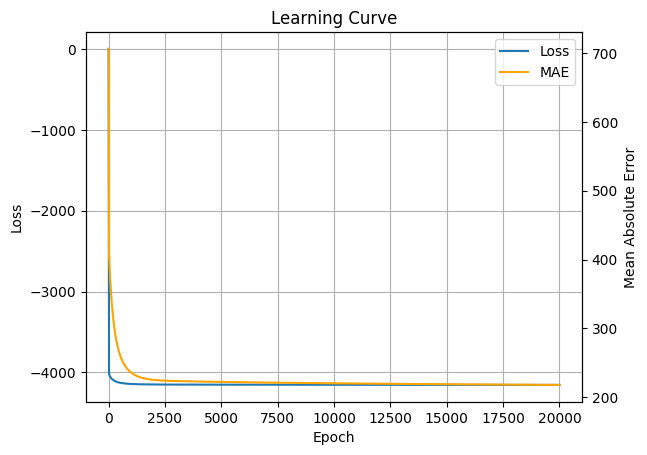

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(metrics_history['loss'], label='Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.grid(True)

ax2 = ax.twinx()
ax2.plot(metrics_history['MAE'], color='orange', label='MAE')
ax2.set_ylabel('Mean Absolute Error')

plt.title('Learning Curve')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

final_train_mae = metrics_history['MAE'][-1]
test_mae = mean_absolute_error(model.decision_function(X_test), Y_test)

print(f'Final train MAE: {final_train_mae:.3f}')
print(f'Test MAE: {test_mae:.3f}')


### 🔁 Baseline Comparison: Linear Regression

To assess whether the Poisson regression model offers a meaningful improvement, we also train a **linear regression** model on the same data.

In [10]:
from courselib.models.linear_models import LinearRegression

w = [0]*X.shape[1]
b = 0

model = LinearRegression(w, b, optimizer)
metrics_history = model.fit(
    X_train,
    Y_train,
    num_epochs=20000,
    batch_size=len(X_train),
    compute_metrics=True,
    metrics_dict=metrics_dict
)

#### Learning Curve and MAE

Final train MAE: 428.794
Test MAE: 420.758


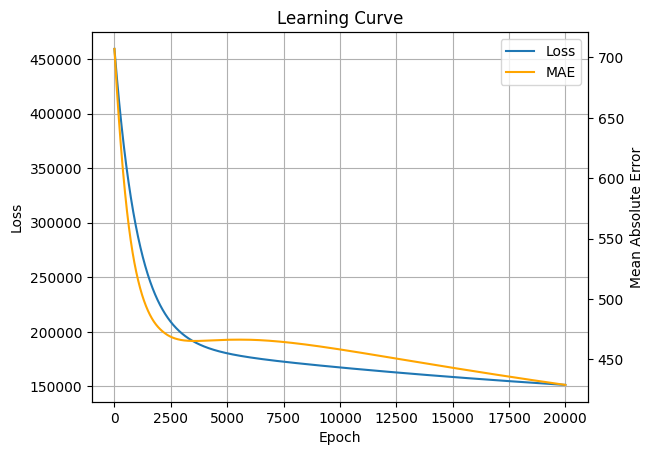

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(metrics_history['MSE'], label='Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.grid(True)

ax2 = ax.twinx()
ax2.plot(metrics_history['MAE'], color='orange', label='MAE')
ax2.set_ylabel('Mean Absolute Error')

plt.title('Learning Curve')
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

final_train_mae = metrics_history['MAE'][-1]
test_mae = mean_absolute_error(model.decision_function(X_test), Y_test)

print(f'Final train MAE: {final_train_mae:.3f}')
print(f'Test MAE: {test_mae:.3f}')


We observe that the **Poisson regression model significantly outperforms** the linear regression baseline on this task.